In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [7]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


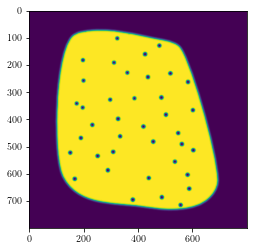

In [9]:
mask_file = 'mask_simple800x800.png'
psfile = 'point_sources_800x800.png'
psapod = 2


#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread(mask_file))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread(psfile))
point_sources = gaussian_filter(point_sources, psapod) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)
        
plt.imshow(apodized_mask)
plt.savefig('figures/apodized_masked_%dx%d.pdf'%(nX, nY),bbox_inches='tight')


In [10]:
fsky = np.sum(apodized_mask) / np.sum(np.ones_like(apodized_mask))

In [11]:
in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key != 'kCmbF_1'):
            continue
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

kCmbF_1 (500, 800, 401)


In [12]:
pairs = [
#    [0,0], #N0
#    [0,1], #kappa
#    [1,0], #kappa
#    [0,2], #N1
#    [1,1], #N1
#    [2,0], #N1
#     [0,3], #should vanish
#     [1,2], #should vanish
#     [2,1], #should vanish
#     [3,0], #should vanish
#     [0,4], #N2 
#     [1,3], #N2
#     [2,2], #N2
#     [3,1], #N2
#     [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]


data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [13]:
nBins=51

In [14]:
data = {}
# pbar = trange(len(pairs))
for file_idx in trange(1,51):
    for pair_idx in range(len(pairs)):
        pair = pairs[pair_idx]
        
        f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_FILE%d_pair_%d_%d_MASKED.pkl'%(file_idx, pair[0], pair[1]), 'rb')  
        c_data = pickle.load(f)
        f.close()        
        for key in c_data:
            if(key not in data.keys()):
                data[key] = np.array(c_data[key])
            else:
                data[key] = np.vstack((data[key], np.array(c_data[key])))  
#             print(np.shape(data[key]))

100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


In [15]:
for key in data:
    print(key, np.shape(data[key]))

-1-1_m (500, 800, 401)
-1-1_m_sqrtN (500, 800, 401)
-2-2_m (500, 800, 401)
-2-2_m_sqrtN (500, 800, 401)


In [16]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [17]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/mean_field_800x800_20x20.pkl', 'rb') 
mean_field = pickle.load(f)
f.close()

In [18]:
nBins=51

ps_data = {}

# #estimate RDN0
# ck = 'RDN(0)'

# def tmp_combine_Cl(Cls_tot):
#     n_runs = np.shape(Cls_tot)[0]
#     lCen = Cls_tot[0][0]
#     Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
# #     sCls =  np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))
#     return lCen, Cls, sCls


# for d_idx in trange(len(in_data['totalF_1'])):
#     RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d.pkl'%(d_idx)
#     c_ps_data = None
#     try:
#         with open(RDN0_fname,"rb") as f:
#             c_ps_data = pickle.load(f)
#     except IOError:
#         continue
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array(c_ps_data[ck])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array(c_ps_data[ck])))  
# print(ps_data[ck].shape)

# #estimate N0
# ck = 'N0'

# for data_idx in range(len(data['00'])):
#     q00 = data['00'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  



# #estimate kk
# ck = 'kk'


# for data_idx in range(min(len(data['01']), len(data['10']))):
#     q01 = data['01'][data_idx]
#     q10 = data['10'][data_idx]
#     kCmbFourier = in_data['kCmbF_1'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier, nBins=15)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <QE QE>
ck = 'QEQE'
for data_idx in trange(len(data['-1-1_m'])):
    QE = data['-1-1_m'][data_idx]

    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE-mean_field, nBins=nBins)
    c_ps_data[ck][1] /= fsky
    c_ps_data[ck][2] /= fsky

    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate Nhat
ck = 'Nhat'
for data_idx in trange(len(data['-1-1_m_sqrtN'])):
    sqrtNhat = data['-1-1_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    c_ps_data[ck][1] /= fsky**2
    c_ps_data[ck][2] /= fsky**2
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  

#estimate GRF Nhat
ck = 'GRF'
for data_idx in trange(len(data['-2-2_m_sqrtN'])):
    sqrtNhat = data['-2-2_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <kT kT>
ck = 'kT'

for data_idx in trange(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=kT, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  





ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])



import numpy as np
from multiprocessing import Pool
from tqdm import trange

# Define a function to compute Ntheory_evaled for a given iteration
def compute_Ntheory_evaled(_):
    # Replace your original code here
    t0, t1 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
    t2 = np.zeros_like(t1)
    return [t0, t1, t2]

# Set the number of iterations for parallel processing
num_iterations = 500

# Create a pool of worker processes using all available CPU cores
pool = Pool()

# Use the map function to parallelize the computation of Ntheory_evaled
Ntheory_evaled = list(tqdm(pool.imap(compute_Ntheory_evaled, range(num_iterations)), total=num_iterations))

# Convert the list of results to a NumPy array
Ntheory_evaled = np.array(Ntheory_evaled)

# Clean up the pool of worker processes
pool.close()
pool.join()

# Continue with your original code
ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-Ntheory_evaled])

100%|██████████| 500/500 [00:08<00:00, 58.82it/s]


500 (500, 3, 50)


100%|██████████| 500/500 [01:12<00:00,  6.85it/s]


500 (500, 3, 50)


In [32]:
labels={
    'N0':r'$N^{(0)}$',
    'GRF':r'$\hat N$ on GRF',
    'kT': r'$\left<\kappa\kappa\right>$',
    'kk':r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>$',
    'N1':r'$N^{(1)}$',
    'N2':r'$N^{(2)}$',
    'N2+':r'$N^{(2)}+\dots$',
    'N3+':r'$N^{(3)}+\dots$',
    'RDN(0)':r'${\rm RDN}^{(0)}$',
    'RDN(0)o2':r'${\rm RDN}^{(0)}$',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',
    'QEQE-Nhat':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$',
    'QEQE-RDN(0)':r'$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$',
    'Nhat':r'$\hat N$',
    'N1+':r'$N^{(1)}+\dots$',
    'KK+N1+': r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>+N^{(1)}+\dots$',
    'QEQE-2Nhat+Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-2\hat N+N_{\rm theory}$',
    'QEQE-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}$',
    'QEQE-Ntheory-N1':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}-N^{(1)}$',
    'QEQE-N0':r'$\left<\hat\kappa\hat\kappa\right>- N^{(0)}$',
    'QEQE-kTkT-Nhat': r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-\hat N$',
    'QEQE-kTkT-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-N_{\rm theory}$',
    'QEQE-kTkT-RDN(0)':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-{\rm RDN}^{(0)}$',
    'kTW2':r'$\left<\kappa\kappa\right>$ Mode Coupling Approx',
}

def graph_from_keys_legacy(c_keys, offset=0.03, factor=lambda x:1, pN1 = False):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
    if(len(c_keys)<=3):
        colors = dict(zip(c_keys, ['red', 'blue', 'green', ]))
    fig,ax = plt.subplots(nrows=1, figsize=(10,8))
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20

    ell = baseMap.l.flatten()
    theory=[fKK, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, factor(L)*ClExpected, sty, label=l)
    
    if(pN1):
        n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
        indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
        bins = n1[0]
        n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
        for i in range(len(indices)):
            if(indices[i] != 'TT'):
                continue        
            n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
            KK = fKK(bins)

            phiphi =  -2. * KK / bins**2
            phiphi *=  -2./ bins**2
            phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

            pp_n1 = phiphi+n1_pp

            KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
            KK_n1 *= - bins**2 / 2
            KK_n1 *= - bins**2 / 2
            plt.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')

    for key in c_keys:
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
        Cl = factor(lCen)*Cl
        sCl = factor(lCen)*sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        
        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])
        tmp_data = {
            'x': lCen[Ineg],
            'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
            'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])
    ax.set_title('Masked')

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin,2*lMax)
    ax.set_ylim(1.1e-10,.9e-3)
    return fig, ax

def graph_from_keys(c_keys, offset=0.03, factor=lambda x:1, pN1 = False):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
    if(len(c_keys)<=3):
        colors = dict(zip(c_keys, ['red', 'blue', 'mediumseagreen']))
    
    fig = plt.figure(figsize =(12, 12))

    axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2))]
    ax =axs[0]
    res_ax = axs[1]
    
    res_ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
    res_ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
#     res_ax.set_yscale('symlog', linthresh=1e-1) 
    res_ax.set_xscale('log')
    res_ax.axhline(0, c='k')
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20

    ell = baseMap.l.flatten()
    theory=[fKK, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, factor(L)*ClExpected, sty, label=l)
    
    pN1ax = None
    fKK_n1 = None
    if(pN1):
        pN1ax = fig.add_axes((0.2, -0.2, .75, .2))
        
        n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
        indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
        bins = n1[0]
        n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
        for i in range(len(indices)):
            if(indices[i] != 'TT'):
                continue        
            n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
            KK = fKK(bins)

            phiphi =  -2. * KK / bins**2
            phiphi *=  -2./ bins**2
            phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

            pp_n1 = phiphi+n1_pp

            KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
            KK_n1 *= - bins**2 / 2
            KK_n1 *= - bins**2 / 2
            
            fKK_n1 = interp1d(bins, KK_n1, kind='linear', bounds_error=False, fill_value=0.)
            ax.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')

    for key in reversed(c_keys):
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
        Cl = factor(lCen)*Cl
        sCl = factor(lCen)*sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=0.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
#         ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        
        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=0.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])
        tmp_data = {
            'x': lCen[Ineg],
            'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
            'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
#         ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])
        KK = np.array(list(map(fKK,lCen-tmp)))
    
        res_ax.errorbar(lCen, (Cl-KK)/KK, yerr=sCl/KK, alpha=0.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
        if(pN1):
            pN1ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
            pN1ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
            pN1ax.set_yscale('symlog', linthresh=1e-1) 
            pN1ax.set_xscale('log')
            pN1ax.axhline(0, c='k')
            pN1ax.set_xscale('log')
            pN1ax.set_ylabel(r'Residual to $+N^{(1)}$')
            pN1ax.set_xlim(lMin,2*lMax)
            pN1ax.set_ylim(-.98e0, .98e0)
    
            KKN1 = np.array(list(map(fKK_n1, lCen-tmp)))
            pN1ax.errorbar(lCen, (Cl-KKN1)/KKN1, yerr=sCl/KK, alpha=0.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])
    ax.set_title('Masked')

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin,2*lMax)
    ax.set_ylim(1.1e-10,.9e-3)
    
    res_ax.set_xscale('log')
    res_ax.set_ylabel(r'Residual')
    res_ax.set_xlim(lMin,2*lMax)
    res_ax.set_ylim(-.15, .15)
    if(not pN1):
        res_ax.set_xlabel(r'$\ell$')
    else:
        pN1ax.set_xlabel(r'$\ell$')
    return fig, ax

In [20]:
Ntheory_evaled.shape

(500, 3, 50)

In [55]:
#estimate <kT kT>
ck = 'kTW2'
maskedFourier = baseMap.fourier(apodized_mask)

del ps_data[ck]
for data_idx in trange(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    kTW2 = kT*maskedFourier**2

    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=kTW2, nBins=nBins)
    print(c_ps_data[ck][1])
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  


  1%|          | 6/500 [00:00<00:09, 52.19it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68404619e-14
 0.00000000e+00 4.05066784e-16 0.00000000e+00 3.77808727e-15
 1.58587211e-16 8.81012946e-17 1.06640876e-18 7.99191629e-18
 3.01239112e-18 8.73676155e-19 2.64645259e-19 8.93105864e-20
 2.30300199e-20 5.58300009e-21 2.66906093e-21 4.16840631e-22
 1.26367382e-22 4.61557713e-23 1.31783403e-23 2.30475780e-24
 3.72123694e-25 3.24079649e-26 5.74124746e-28 2.06891234e-29
 1.38030204e-29 5.37062666e-31 2.76348078e-34 3.76520425e-35
 2.93283333e-39 7.85238405e-42 4.11724549e-43 6.08837227e-44
 1.51916055e-44 6.38009064e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.08386

  4%|▎         | 18/500 [00:00<00:09, 52.41it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.35820390e-14
 0.00000000e+00 9.37546025e-16 0.00000000e+00 6.70772919e-15
 1.30851250e-16 1.88999104e-17 6.91437156e-18 2.83182172e-18
 2.69152882e-18 1.22678008e-18 3.43348367e-19 3.95156622e-20
 9.52178099e-21 5.84746979e-21 1.23928829e-21 5.49532472e-22
 1.11286056e-22 9.82895826e-23 1.05903871e-23 2.48806077e-24
 3.94784230e-25 3.20677669e-26 6.62368297e-28 2.12469677e-29
 1.34790610e-29 5.35431509e-31 2.72005014e-34 3.69070856e-35
 2.86631363e-39 7.88175575e-42 4.16136832e-43 5.94828698e-44
 1.51856401e-44 6.43846387e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.96551

  6%|▌         | 30/500 [00:00<00:08, 52.37it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.29940909e-15
 0.00000000e+00 3.70807992e-15 0.00000000e+00 3.89736394e-15
 5.91021227e-17 1.02402384e-16 4.42129779e-18 3.13268017e-18
 5.31260311e-18 1.71779751e-18 2.21183595e-19 4.87384036e-20
 1.13520889e-20 6.03668247e-21 1.70128590e-21 3.07103707e-22
 1.87950791e-22 4.71083513e-23 1.13713199e-23 2.32064538e-24
 4.12776473e-25 2.47753120e-26 6.41643135e-28 2.06789879e-29
 1.47748324e-29 5.27644082e-31 2.67489972e-34 3.55143985e-35
 2.65465065e-39 8.18314820e-42 4.11084945e-43 5.89934672e-44
 1.50758947e-44 6.55144873e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.47442

  8%|▊         | 42/500 [00:00<00:08, 52.24it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00027079e-14
 0.00000000e+00 4.25832156e-16 0.00000000e+00 4.63572682e-16
 1.44810128e-16 4.62580851e-17 5.80768693e-18 5.53051896e-18
 1.87718706e-18 1.04054133e-18 2.68288079e-19 2.79022820e-20
 6.91786479e-21 4.30426262e-21 1.61441113e-21 3.42906240e-22
 1.53335519e-22 5.09486261e-23 9.92453371e-24 2.18357302e-24
 3.65185686e-25 2.91700405e-26 6.46913921e-28 1.97409004e-29
 1.33561884e-29 5.32043786e-31 2.77267175e-34 3.53569220e-35
 2.84197552e-39 8.00134097e-42 4.18153643e-43 5.90585109e-44
 1.52192582e-44 6.31489941e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.22808

 11%|█         | 54/500 [00:01<00:08, 52.21it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.17003769e-15
 0.00000000e+00 2.97167969e-16 0.00000000e+00 9.11230653e-16
 4.16226586e-16 7.27953334e-17 9.84781449e-19 3.78720020e-18
 2.91252480e-18 1.00708491e-18 2.58314357e-19 4.61757743e-20
 1.19189862e-20 4.85001999e-21 1.32725905e-21 3.63215319e-22
 1.40444415e-22 5.44836345e-23 1.21539282e-23 2.09230539e-24
 3.98302719e-25 3.43011348e-26 6.39698252e-28 2.16221722e-29
 1.50893810e-29 5.38526193e-31 2.72545559e-34 3.47110684e-35
 2.79703101e-39 7.86474509e-42 4.25818032e-43 5.90630112e-44
 1.49645869e-44 6.44100583e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.52518

 13%|█▎        | 66/500 [00:01<00:08, 52.28it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28699450e-14
 0.00000000e+00 2.47562889e-16 0.00000000e+00 7.59195840e-15
 1.68785787e-16 3.89521069e-17 1.30344754e-18 1.54585826e-17
 1.84395324e-18 7.21046146e-19 2.07223338e-19 2.85244391e-20
 1.42088325e-20 4.20720187e-21 1.60243451e-21 3.33608335e-22
 1.37441149e-22 5.69678656e-23 1.06243507e-23 2.32079476e-24
 3.52385871e-25 3.22554001e-26 7.28599309e-28 1.94195349e-29
 1.44435468e-29 5.11173906e-31 2.79427182e-34 3.40780756e-35
 2.49103500e-39 7.72409842e-42 4.20134382e-43 5.89231162e-44
 1.51237665e-44 6.30783545e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.48740

 14%|█▍        | 72/500 [00:01<00:08, 52.42it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.47890352e-14
 0.00000000e+00 2.93785241e-15 0.00000000e+00 1.28147079e-15
 4.00385647e-16 9.71905724e-18 2.45643288e-18 1.49587215e-18
 6.86988380e-19 8.97744682e-19 1.83524236e-19 6.07605430e-20
 1.06742817e-20 5.53295847e-21 1.96204195e-21 4.07094860e-22
 1.04402472e-22 6.80429500e-23 1.28390366e-23 2.47225732e-24
 3.08458075e-25 3.05453281e-26 6.60888368e-28 2.08495824e-29
 1.39348196e-29 5.38539851e-31 2.84340655e-34 3.46719374e-35
 2.82947487e-39 7.61222429e-42 4.11019731e-43 5.92276542e-44
 1.49414075e-44 6.30032792e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28351

 17%|█▋        | 84/500 [00:01<00:08, 51.10it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.43673969e-14
 0.00000000e+00 8.44389207e-16 0.00000000e+00 9.12020612e-16
 2.61335197e-16 3.71418266e-17 1.71504067e-18 5.58473127e-18
 3.98974684e-18 8.14850133e-19 2.34317581e-19 4.30632632e-20
 1.46139630e-20 1.04509972e-20 2.14363542e-21 3.72461308e-22
 1.41305751e-22 5.53391306e-23 1.26671026e-23 2.63473672e-24
 3.53806340e-25 3.24199437e-26 6.22186999e-28 2.18405167e-29
 1.38413742e-29 5.21149674e-31 2.66137727e-34 3.53790050e-35
 2.74192393e-39 7.80722432e-42 4.13249137e-43 5.93654469e-44
 1.52058382e-44 6.44101869e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.15712

 19%|█▉        | 96/500 [00:01<00:07, 51.87it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20788470e-14
 0.00000000e+00 7.46848404e-16 0.00000000e+00 5.52838623e-16
 7.81396894e-16 1.25202824e-17 2.52775052e-18 2.24040792e-18
 2.75768637e-18 7.22629016e-19 2.12548516e-19 3.44568729e-20
 1.03509542e-20 7.25884549e-21 1.29392566e-21 3.75391161e-22
 1.23945789e-22 7.31717516e-23 1.01876349e-23 2.33601298e-24
 3.21344438e-25 3.65094228e-26 5.36212685e-28 2.09201543e-29
 1.44907609e-29 5.37389277e-31 2.74253051e-34 3.57883333e-35
 2.81035336e-39 7.66451277e-42 4.14371965e-43 5.98307349e-44
 1.51085493e-44 6.31700957e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.98556

 22%|██▏       | 108/500 [00:02<00:07, 52.19it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.22601692e-14
 0.00000000e+00 2.24652968e-16 0.00000000e+00 4.76945267e-15
 4.88007834e-16 2.99988332e-17 1.04316137e-18 1.29380911e-17
 3.05422677e-18 1.13882208e-18 2.38439995e-19 7.28274820e-20
 9.90728580e-21 5.90870933e-21 1.39574554e-21 3.17348564e-22
 1.04166041e-22 5.85593689e-23 1.15511008e-23 2.38716046e-24
 3.40500907e-25 4.00488720e-26 5.81310952e-28 2.07078869e-29
 1.42258440e-29 5.21995785e-31 2.74955842e-34 3.71261764e-35
 2.82799297e-39 7.60882960e-42 4.10516570e-43 6.03488062e-44
 1.52260691e-44 6.40306579e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.49152

 24%|██▍       | 120/500 [00:02<00:07, 52.29it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.51342175e-13
 0.00000000e+00 1.48212053e-16 0.00000000e+00 5.42512046e-15
 2.26913988e-16 1.86641580e-17 2.88535812e-18 4.07448271e-18
 5.19761847e-18 2.35917672e-18 1.32415882e-19 4.64458290e-20
 1.21669146e-20 5.07737733e-21 1.92495486e-21 4.41115998e-22
 1.25670613e-22 4.86040302e-23 1.16932942e-23 2.46836991e-24
 3.79100532e-25 3.02160905e-26 6.47362167e-28 1.90923680e-29
 1.33592107e-29 5.04312878e-31 2.73375534e-34 3.67238743e-35
 2.88720075e-39 7.84505252e-42 4.18039745e-43 5.89763901e-44
 1.52079766e-44 6.35316191e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.46581

 26%|██▋       | 132/500 [00:02<00:07, 52.41it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.66499907e-14
 0.00000000e+00 1.17979031e-15 0.00000000e+00 1.44382356e-15
 4.95357439e-17 4.08800047e-17 6.20532039e-18 2.39288333e-18
 2.61318756e-18 3.61155720e-19 2.88944638e-19 3.42170740e-20
 8.82418408e-21 4.11799994e-21 1.59012687e-21 4.90217885e-22
 1.91147539e-22 5.34810562e-23 1.30143674e-23 2.01166557e-24
 3.71038647e-25 2.86380832e-26 6.83012120e-28 2.09049789e-29
 1.39849917e-29 5.27537006e-31 2.74379486e-34 3.47658128e-35
 2.74495615e-39 8.07194889e-42 4.13512670e-43 5.99947486e-44
 1.53100422e-44 6.43336953e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.18282

 28%|██▊       | 138/500 [00:02<00:06, 52.36it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.10275460e-13
 0.00000000e+00 9.98615730e-17 0.00000000e+00 1.94680401e-15
 2.77997517e-16 3.65239099e-17 6.33685049e-18 9.17909641e-18
 3.53953733e-18 5.81768418e-19 1.20660631e-19 5.04170245e-20
 1.44857141e-20 5.60733818e-21 2.22308916e-21 4.42115560e-22
 1.20908206e-22 7.80031125e-23 1.16492300e-23 2.42609989e-24
 3.50111993e-25 2.90457237e-26 5.48342581e-28 2.17400304e-29
 1.47960697e-29 5.22834366e-31 2.82274441e-34 3.42708767e-35
 2.86364739e-39 7.77777044e-42 4.19372563e-43 6.05077048e-44
 1.51204974e-44 6.27908735e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.26473

 30%|███       | 150/500 [00:02<00:06, 52.37it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90727905e-14
 0.00000000e+00 6.60384517e-16 0.00000000e+00 8.33339363e-16
 6.23844223e-16 1.77972207e-17 1.06318688e-17 2.71336970e-18
 2.67407944e-18 3.74914345e-19 3.25687884e-19 2.71195104e-20
 1.06177633e-20 8.16118122e-21 1.65458468e-21 4.35806173e-22
 1.35389660e-22 6.09560008e-23 1.28409477e-23 2.47486589e-24
 3.41369932e-25 3.19501459e-26 6.49454134e-28 2.00058812e-29
 1.44865890e-29 5.08821492e-31 2.68523523e-34 3.41586649e-35
 2.81487429e-39 7.92439097e-42 4.16141399e-43 5.84891658e-44
 1.51059388e-44 6.43289593e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.44435

 32%|███▏      | 162/500 [00:03<00:06, 52.36it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.60552508e-15
 0.00000000e+00 2.00669651e-15 0.00000000e+00 6.13785512e-15
 2.40398395e-16 4.47088677e-17 6.10560011e-18 3.97248623e-18
 2.44471378e-18 5.44801629e-19 3.14658924e-19 3.36206223e-20
 1.64108594e-20 4.34213252e-21 1.31264996e-21 5.33532956e-22
 1.67972889e-22 5.28726005e-23 9.89322211e-24 2.44261781e-24
 4.07122041e-25 3.36124218e-26 5.57509585e-28 2.10956893e-29
 1.45191978e-29 5.44638699e-31 2.72807379e-34 3.58540300e-35
 2.88035989e-39 7.65135661e-42 4.12038354e-43 5.86873078e-44
 1.52235386e-44 6.31786970e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.68702

 35%|███▍      | 174/500 [00:03<00:06, 51.92it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.12181946e-13
 0.00000000e+00 1.77079975e-15 0.00000000e+00 4.60812590e-15
 6.12921056e-16 6.25840681e-17 5.74927023e-19 6.05348970e-18
 3.34589450e-18 7.52271753e-19 5.05435977e-19 4.32485081e-20
 9.45686278e-21 6.49632138e-21 1.54352895e-21 3.85236981e-22
 1.11443658e-22 8.42241250e-23 1.09774521e-23 2.46312285e-24
 3.59280354e-25 3.16233434e-26 6.49827197e-28 2.13170397e-29
 1.44090654e-29 5.31195461e-31 2.89293113e-34 3.65756601e-35
 2.79517303e-39 7.56329066e-42 4.10973043e-43 5.92900076e-44
 1.51543002e-44 6.39243539e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.90372

 37%|███▋      | 186/500 [00:03<00:06, 52.12it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.62970838e-14
 0.00000000e+00 2.48814196e-15 0.00000000e+00 2.78536274e-15
 2.04953250e-16 2.54346160e-17 4.46511447e-19 1.28760960e-17
 1.00626231e-18 4.23797084e-19 4.29776959e-19 6.01725861e-20
 1.03691540e-20 6.20605165e-21 2.35183048e-21 4.84383227e-22
 1.21845024e-22 3.68754069e-23 1.07973660e-23 2.62063687e-24
 3.94830200e-25 3.15259495e-26 7.39038416e-28 1.94986087e-29
 1.38428626e-29 5.15506203e-31 2.81877173e-34 3.74031592e-35
 2.87477019e-39 7.69684156e-42 4.18891516e-43 5.93498954e-44
 1.51012138e-44 6.23182012e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.69945

 40%|███▉      | 198/500 [00:03<00:05, 52.20it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.01104747e-14
 0.00000000e+00 3.45199437e-15 0.00000000e+00 3.15894762e-15
 1.49018022e-16 2.51666862e-17 3.54750116e-18 4.21175464e-18
 1.79597454e-18 5.29846034e-19 5.69445632e-19 4.54975853e-20
 1.71311041e-20 6.46348682e-21 1.57778512e-21 4.08432665e-22
 1.91313894e-22 5.90339409e-23 1.09145975e-23 2.50699783e-24
 3.48422048e-25 2.66075223e-26 5.56771167e-28 2.03195225e-29
 1.35335787e-29 5.69736831e-31 2.71335214e-34 3.74993498e-35
 2.83569484e-39 8.03359652e-42 4.21439849e-43 5.97039577e-44
 1.51332266e-44 6.42332980e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.48858

 41%|████      | 204/500 [00:03<00:05, 52.24it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.72674268e-14
 0.00000000e+00 4.17827483e-15 0.00000000e+00 2.03996230e-15
 2.43278241e-16 2.65822143e-16 1.54316389e-18 3.27981981e-18
 2.00088291e-18 8.33876336e-19 2.90379026e-19 2.13068509e-20
 6.41015966e-21 5.62831167e-21 1.13920236e-21 5.46861098e-22
 1.94087930e-22 6.58089521e-23 1.07828824e-23 2.37724874e-24
 3.35593986e-25 2.88862231e-26 5.81562608e-28 2.18109002e-29
 1.38291709e-29 5.25627869e-31 2.86179026e-34 3.58457322e-35
 2.75455601e-39 7.66043185e-42 4.16900400e-43 6.03789812e-44
 1.51419717e-44 6.32511181e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.27518

 43%|████▎     | 216/500 [00:04<00:05, 52.23it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.29212321e-15
 0.00000000e+00 3.86796514e-16 0.00000000e+00 2.93120691e-15
 2.94864358e-16 2.29190647e-17 6.23609452e-18 4.80802774e-18
 1.95050623e-18 5.55160303e-19 3.79076730e-19 3.66905497e-20
 6.63316209e-21 5.81775965e-21 1.14947060e-21 3.52161440e-22
 1.43554910e-22 5.26616901e-23 1.20015794e-23 2.23904473e-24
 3.70342129e-25 3.14765606e-26 6.46187826e-28 2.11798872e-29
 1.35401685e-29 5.53638210e-31 2.87897189e-34 3.70069256e-35
 2.63455374e-39 7.79923309e-42 4.16837610e-43 5.94254783e-44
 1.52176862e-44 6.34778713e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.50858

 46%|████▌     | 228/500 [00:04<00:05, 52.40it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.34564961e-14
 0.00000000e+00 1.33593108e-15 0.00000000e+00 3.20465986e-15
 2.40379301e-16 1.22524770e-16 9.14891570e-18 2.88565761e-18
 1.28076083e-18 1.62470126e-18 2.41546348e-19 6.17039157e-20
 2.01360356e-20 7.03344615e-21 1.47150370e-21 3.93772741e-22
 1.20733672e-22 5.34180915e-23 1.01091055e-23 2.56242764e-24
 3.37088050e-25 3.21632698e-26 6.70165673e-28 2.06829097e-29
 1.48272236e-29 5.28534895e-31 2.77236960e-34 3.61767173e-35
 2.72617947e-39 8.06485675e-42 4.13540885e-43 6.01347862e-44
 1.50707424e-44 6.31825490e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.69619

 48%|████▊     | 240/500 [00:04<00:04, 52.30it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.81128399e-14
 0.00000000e+00 1.08005022e-15 0.00000000e+00 1.73569971e-15
 4.15246785e-16 3.10365694e-17 2.46664551e-18 4.37716877e-18
 2.63097023e-18 9.05149342e-19 3.94085150e-19 7.09145528e-20
 1.45263893e-20 9.47460404e-21 1.70956909e-21 4.32652533e-22
 1.97587852e-22 6.61483553e-23 1.24507689e-23 2.36782298e-24
 3.51520137e-25 3.09168000e-26 5.40231908e-28 1.98668983e-29
 1.37528903e-29 5.25325734e-31 2.87960174e-34 3.47922486e-35
 2.61537959e-39 8.08120847e-42 4.18462126e-43 5.85456732e-44
 1.50789623e-44 6.35542116e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.74126

 50%|█████     | 252/500 [00:04<00:04, 52.21it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.05646966e-14
 0.00000000e+00 1.39272663e-15 0.00000000e+00 1.71035728e-15
 5.32604577e-16 3.24922191e-17 2.57952984e-18 6.51895877e-18
 7.64584931e-19 7.26235084e-19 1.58316210e-19 5.91788269e-20
 1.20276603e-20 7.10196118e-21 1.79930618e-21 4.01964780e-22
 1.49422427e-22 4.72961317e-23 1.21002470e-23 2.06269098e-24
 3.72554791e-25 3.04407850e-26 5.82833610e-28 2.27897741e-29
 1.43479830e-29 5.24367600e-31 2.74751233e-34 3.59759128e-35
 2.72894813e-39 7.77127409e-42 4.13429252e-43 5.98066972e-44
 1.51218771e-44 6.35649106e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.58786

 53%|█████▎    | 264/500 [00:05<00:04, 52.25it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.20263643e-14
 0.00000000e+00 1.19795954e-15 0.00000000e+00 1.04927089e-15
 1.29870670e-16 2.33608776e-17 3.58557312e-18 1.61030376e-18
 1.39539924e-18 3.66509832e-19 4.07847690e-19 5.10337293e-20
 1.06834969e-20 7.19594642e-21 1.61967890e-21 4.61509005e-22
 1.03861713e-22 5.82667561e-23 1.11177369e-23 2.45998908e-24
 3.72204976e-25 3.84213478e-26 5.89953820e-28 2.09406241e-29
 1.36210841e-29 5.14223590e-31 2.97827523e-34 3.93979280e-35
 2.76069604e-39 7.86462175e-42 4.20601133e-43 6.02374934e-44
 1.50829243e-44 6.26543631e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.65840

 54%|█████▍    | 270/500 [00:05<00:04, 52.29it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.78452698e-14
 0.00000000e+00 2.61061888e-15 0.00000000e+00 2.16085981e-15
 1.40992673e-16 4.61898526e-17 3.00681674e-18 4.42419698e-18
 1.19749135e-18 3.63636746e-19 4.02550632e-19 5.53989713e-20
 1.17763801e-20 4.89472250e-21 1.19210793e-21 4.58444033e-22
 1.50391457e-22 5.60685035e-23 1.04413074e-23 2.32099670e-24
 3.38714292e-25 3.54448839e-26 5.71882293e-28 2.29966114e-29
 1.31935682e-29 5.13010071e-31 2.76181654e-34 3.60301483e-35
 2.87326911e-39 7.78110977e-42 4.15981079e-43 5.94546552e-44
 1.50856394e-44 6.20861421e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.16299

 56%|█████▋    | 282/500 [00:05<00:04, 52.34it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.69580426e-14
 0.00000000e+00 2.43956244e-15 0.00000000e+00 5.51538103e-15
 2.70863046e-16 3.98388914e-17 5.21509785e-18 8.67816864e-18
 2.56766936e-18 1.51310173e-18 4.16661685e-19 3.67159629e-20
 1.22534195e-20 4.81366971e-21 2.15606504e-21 3.45649434e-22
 1.30719076e-22 6.72897741e-23 1.17353893e-23 2.71271091e-24
 3.60897030e-25 2.73467662e-26 6.36652133e-28 1.97594225e-29
 1.40394335e-29 5.66024554e-31 2.76522823e-34 3.53151901e-35
 2.59974101e-39 7.66434663e-42 4.20884242e-43 6.01186227e-44
 1.52663800e-44 6.41203368e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.66741

 59%|█████▉    | 294/500 [00:05<00:03, 52.33it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.87580094e-14
 0.00000000e+00 2.59552729e-15 0.00000000e+00 3.04167956e-15
 1.63351309e-16 3.71133680e-17 1.54791065e-18 4.25570516e-18
 3.00859528e-18 4.52366689e-19 2.18011162e-19 2.51960067e-20
 1.08360126e-20 6.10985337e-21 2.59628449e-21 4.20616019e-22
 1.06360362e-22 4.60412890e-23 1.27881436e-23 2.42286652e-24
 3.43604476e-25 3.25485514e-26 6.15270950e-28 2.22524418e-29
 1.39907590e-29 5.41872124e-31 2.64745492e-34 3.68121282e-35
 2.63561103e-39 7.97604628e-42 4.18751039e-43 5.96957213e-44
 1.50737062e-44 6.39167530e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.72558

 61%|██████    | 306/500 [00:05<00:03, 52.47it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.40146202e-14
 0.00000000e+00 1.69076610e-15 0.00000000e+00 8.29008703e-16
 9.77923249e-17 6.06047309e-17 3.63411143e-18 1.29419632e-18
 8.85377163e-19 7.40477191e-19 2.50242406e-19 6.44704589e-20
 1.45568760e-20 5.12221951e-21 1.33168153e-21 3.89326417e-22
 1.93564685e-22 6.49105226e-23 9.88478472e-24 2.13853019e-24
 3.91493689e-25 3.28300019e-26 6.57474880e-28 2.19338932e-29
 1.46031569e-29 5.47323077e-31 2.62371167e-34 3.42677083e-35
 2.88616096e-39 7.90834702e-42 4.17989368e-43 5.90720514e-44
 1.51790438e-44 6.48430938e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.16893

 64%|██████▎   | 318/500 [00:06<00:03, 52.48it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.58240510e-14
 0.00000000e+00 8.52693871e-16 0.00000000e+00 8.36676073e-15
 5.64620879e-16 1.24495768e-17 9.01412487e-18 3.16774110e-18
 4.60879492e-18 2.56923146e-19 3.14965082e-19 5.63573006e-20
 1.38199875e-20 4.48315601e-21 1.46369651e-21 3.73391661e-22
 1.16038126e-22 5.34108506e-23 1.11780512e-23 2.67955845e-24
 3.55037153e-25 3.11384812e-26 5.96452131e-28 2.07468626e-29
 1.38377787e-29 5.14072849e-31 2.72768948e-34 3.76058799e-35
 2.84219844e-39 7.69447274e-42 4.22869809e-43 5.94910167e-44
 1.52833515e-44 6.44850501e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00272

 66%|██████▌   | 330/500 [00:06<00:03, 52.30it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.61679228e-14
 0.00000000e+00 1.98094763e-15 0.00000000e+00 2.29283466e-15
 4.17578756e-16 1.66846798e-17 3.59343753e-18 5.96872750e-18
 2.82560577e-18 7.01109297e-19 3.29764004e-19 4.69916518e-20
 1.09638356e-20 5.55501138e-21 1.38844190e-21 4.29049289e-22
 1.13080218e-22 4.07706740e-23 1.25545482e-23 2.40247768e-24
 3.43546953e-25 3.02069440e-26 6.25143985e-28 2.10470453e-29
 1.33147525e-29 5.51912128e-31 2.76757698e-34 3.57434952e-35
 2.72114808e-39 7.74656057e-42 4.18082695e-43 5.98449275e-44
 1.51771312e-44 6.47064860e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.48483

 67%|██████▋   | 336/500 [00:06<00:03, 52.30it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.39314431e-14
 0.00000000e+00 2.94731195e-16 0.00000000e+00 1.96442958e-15
 6.14732426e-16 1.85605792e-17 4.76196072e-18 5.87126110e-18
 1.88684077e-18 6.64680169e-19 1.96635401e-19 5.18613001e-20
 8.54038944e-21 4.00599385e-21 7.49720760e-22 5.29140953e-22
 1.06394854e-22 5.95283314e-23 1.34038273e-23 1.98771164e-24
 3.92419827e-25 3.06982785e-26 7.23582862e-28 1.95675112e-29
 1.40893461e-29 5.11302723e-31 2.77886487e-34 3.65303383e-35
 2.69971725e-39 7.93773761e-42 4.09743819e-43 6.02002363e-44
 1.51504800e-44 6.43843161e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.81717

 70%|██████▉   | 348/500 [00:06<00:02, 52.23it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.49370149e-14
 0.00000000e+00 2.29167017e-15 0.00000000e+00 2.61892949e-15
 2.68206399e-16 5.28268936e-17 6.76611342e-19 2.82681458e-18
 2.41604104e-18 3.52036761e-19 7.10335765e-19 7.78135094e-20
 9.93163991e-21 9.85449457e-21 1.34541150e-21 5.89627382e-22
 1.17210868e-22 4.92404630e-23 1.05075422e-23 2.03002043e-24
 3.78359020e-25 2.84223757e-26 6.21061473e-28 2.04769232e-29
 1.50493899e-29 4.97901203e-31 2.71280952e-34 3.59975163e-35
 2.61782331e-39 7.60760673e-42 4.16571697e-43 6.00424875e-44
 1.51928346e-44 6.35798701e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.33176

 72%|███████▏  | 360/500 [00:06<00:02, 52.25it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.23925559e-13
 0.00000000e+00 4.45609263e-16 0.00000000e+00 2.41251305e-15
 3.42572729e-16 2.74796267e-17 1.72767465e-18 9.09622584e-18
 3.00578435e-18 7.13782883e-19 2.81617903e-19 7.22015325e-20
 1.75375660e-20 9.91695305e-21 1.58139875e-21 3.40340087e-22
 1.30623733e-22 3.73471040e-23 1.03312289e-23 2.76780296e-24
 3.15676784e-25 3.32295755e-26 6.31701078e-28 2.08999420e-29
 1.39960716e-29 5.39504365e-31 2.68807882e-34 3.68024448e-35
 2.59220802e-39 7.34411027e-42 4.08599839e-43 5.97547710e-44
 1.53494225e-44 6.49073553e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.38530

 74%|███████▍  | 372/500 [00:07<00:02, 52.17it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.43099484e-14
 0.00000000e+00 5.04810706e-15 0.00000000e+00 1.92291848e-15
 5.20794914e-16 7.64584197e-17 4.20386742e-18 8.99813199e-18
 1.39408037e-18 8.04946577e-19 3.71999654e-19 5.73773000e-20
 1.71140496e-20 5.28704753e-21 1.35862162e-21 4.75445605e-22
 1.65368198e-22 3.72261908e-23 1.07435409e-23 2.17798604e-24
 3.72685386e-25 3.04620722e-26 5.92563726e-28 2.22011891e-29
 1.41597405e-29 5.27501745e-31 2.74999123e-34 3.74115668e-35
 2.97180816e-39 7.86166720e-42 4.16314238e-43 5.96074883e-44
 1.49257962e-44 6.41662096e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.27961

 77%|███████▋  | 384/500 [00:07<00:02, 52.19it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.16828581e-14
 0.00000000e+00 1.64089080e-15 0.00000000e+00 2.38389556e-15
 5.63336175e-16 4.12569637e-17 1.13017604e-18 6.59181773e-18
 3.04991185e-18 1.00538651e-18 1.63329944e-19 4.19474136e-20
 8.92430887e-21 6.35851846e-21 1.89208085e-21 6.08749530e-22
 1.70364798e-22 5.78843305e-23 1.60846737e-23 2.41588564e-24
 3.55401625e-25 3.06455185e-26 6.07925873e-28 2.13544413e-29
 1.38776399e-29 5.26166692e-31 2.95189936e-34 3.67802910e-35
 2.84818215e-39 7.76728634e-42 4.18350048e-43 5.96071032e-44
 1.54027183e-44 6.42335257e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.19213

 79%|███████▉  | 396/500 [00:07<00:01, 52.15it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.93052885e-14
 0.00000000e+00 3.64573240e-16 0.00000000e+00 2.63751650e-15
 2.80387757e-16 7.17814674e-17 3.09063363e-18 8.07196352e-18
 1.75699895e-18 1.62205564e-18 2.47738953e-19 3.03456492e-20
 8.56567260e-21 4.09316414e-21 1.12566172e-21 3.57625355e-22
 1.67164687e-22 6.79529235e-23 1.10170320e-23 2.31178557e-24
 3.49123950e-25 3.26962212e-26 5.70598385e-28 2.13767969e-29
 1.37984924e-29 5.11513572e-31 2.77222884e-34 3.76917191e-35
 2.58213926e-39 7.74014339e-42 4.19578054e-43 6.09358061e-44
 1.52895999e-44 6.38520681e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.87032

 80%|████████  | 402/500 [00:07<00:01, 52.15it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.92178730e-14
 0.00000000e+00 1.46569558e-16 0.00000000e+00 7.78126953e-16
 1.78554294e-16 2.50184343e-17 6.66871448e-18 1.52928889e-18
 1.52942984e-18 5.68044797e-19 2.00659250e-19 6.92442564e-20
 1.11769738e-20 5.36040344e-21 1.96595892e-21 2.96395273e-22
 1.24023599e-22 7.59848210e-23 1.15650341e-23 2.70642404e-24
 3.33619906e-25 3.00774121e-26 7.72384426e-28 2.07897301e-29
 1.30362581e-29 5.19125596e-31 2.82751756e-34 3.60652473e-35
 2.67962157e-39 7.81126279e-42 4.19372649e-43 5.92667364e-44
 1.53344499e-44 6.40557030e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.42808

 83%|████████▎ | 414/500 [00:07<00:01, 52.10it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.24719981e-15
 0.00000000e+00 3.78365420e-16 0.00000000e+00 1.57975028e-15
 1.94419194e-16 1.00507380e-16 7.37231442e-18 3.14408019e-18
 1.86991084e-18 8.43347814e-19 5.22273034e-19 4.69052529e-20
 9.12457247e-21 6.33131651e-21 1.05238474e-21 4.14775544e-22
 1.61382556e-22 5.68671978e-23 1.07468961e-23 2.26202826e-24
 3.74037047e-25 2.89910641e-26 5.66314857e-28 2.06139443e-29
 1.36782561e-29 5.42453574e-31 2.75809130e-34 3.61271039e-35
 3.00549576e-39 7.79409794e-42 4.13546165e-43 5.97350106e-44
 1.50674425e-44 6.35678572e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.34000

 85%|████████▌ | 426/500 [00:08<00:01, 52.22it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.83828739e-14
 0.00000000e+00 1.16780667e-16 0.00000000e+00 6.53617588e-16
 2.09370793e-16 2.51391772e-17 5.76950277e-18 2.88699848e-18
 2.09868713e-18 1.41410727e-18 2.50827861e-19 3.93516583e-20
 1.06670797e-20 8.83098174e-21 1.72163664e-21 3.88192523e-22
 1.13652834e-22 5.44649785e-23 1.23169989e-23 2.90968877e-24
 3.82476534e-25 3.48117704e-26 5.42981770e-28 2.12956992e-29
 1.43152199e-29 5.68952304e-31 2.68423374e-34 3.64390672e-35
 2.92850473e-39 8.00422778e-42 4.18982757e-43 5.98472259e-44
 1.49439199e-44 6.31905223e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.59461

 88%|████████▊ | 438/500 [00:08<00:01, 52.35it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.46588236e-14
 0.00000000e+00 7.76492131e-17 0.00000000e+00 2.82657754e-15
 2.53369361e-16 1.95592162e-17 1.15129150e-17 3.11164607e-18
 1.46642426e-18 5.40838308e-19 3.04019839e-19 4.16311023e-20
 1.28777379e-20 6.39027896e-21 2.28362864e-21 4.08216907e-22
 1.41616493e-22 6.50207423e-23 1.12724899e-23 2.12462150e-24
 3.82574606e-25 3.35482980e-26 6.08131743e-28 2.12853164e-29
 1.44550591e-29 5.08192334e-31 2.74898084e-34 3.45929739e-35
 2.79530915e-39 7.57420957e-42 4.16178680e-43 5.84737143e-44
 1.53079608e-44 6.29248945e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.98169

 90%|█████████ | 450/500 [00:08<00:00, 52.34it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.76532074e-14
 0.00000000e+00 3.35972947e-16 0.00000000e+00 8.95072928e-16
 1.39700933e-16 6.39988318e-17 2.37288111e-18 1.57410277e-18
 4.50927325e-18 6.58443898e-19 1.53250653e-19 3.57208029e-20
 1.04936988e-20 5.89234926e-21 1.23925688e-21 6.70709011e-22
 9.65501230e-23 5.84320505e-23 1.22533864e-23 2.42278142e-24
 3.52890777e-25 3.35626936e-26 6.35735429e-28 2.04217127e-29
 1.38212182e-29 5.33627530e-31 2.90335939e-34 3.55725664e-35
 2.82791534e-39 8.07257865e-42 4.17264644e-43 5.95303510e-44
 1.51763935e-44 6.30957513e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.19586

 92%|█████████▏| 462/500 [00:08<00:00, 52.33it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31789806e-14
 0.00000000e+00 1.56773629e-16 0.00000000e+00 1.02578982e-15
 1.70687342e-16 6.78756266e-17 6.52341891e-18 3.34441741e-18
 7.71208411e-19 5.70358252e-19 3.83967807e-19 4.00067484e-20
 1.19211281e-20 1.00720654e-20 1.40936488e-21 3.79590343e-22
 1.32253834e-22 6.50673108e-23 1.05698081e-23 2.72891011e-24
 3.81287099e-25 3.34126852e-26 5.88783223e-28 1.95787897e-29
 1.34891234e-29 5.24639082e-31 2.91509354e-34 3.42388206e-35
 2.91149549e-39 7.79778256e-42 4.14126804e-43 5.97630154e-44
 1.51423580e-44 6.42681755e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.99926

 94%|█████████▎| 468/500 [00:08<00:00, 52.25it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.94909293e-14
 0.00000000e+00 2.03560076e-15 0.00000000e+00 1.49787959e-15
 2.95298495e-16 5.43935298e-17 9.73113076e-18 6.83749927e-18
 8.76420771e-19 5.53139738e-19 1.87256095e-19 3.17767988e-20
 9.02585665e-21 6.17905003e-21 1.80309060e-21 3.71556916e-22
 1.15723538e-22 5.73963507e-23 1.06787761e-23 2.30627891e-24
 3.30373070e-25 3.35254989e-26 5.99636925e-28 2.22204841e-29
 1.37999367e-29 5.08799261e-31 2.77803771e-34 3.83586783e-35
 2.74726287e-39 7.41992133e-42 4.11414171e-43 5.96494300e-44
 1.52052355e-44 6.36103071e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.97051

 96%|█████████▌| 480/500 [00:09<00:00, 52.14it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.69627579e-14
 0.00000000e+00 2.30741474e-15 0.00000000e+00 2.65184567e-15
 6.69759257e-17 4.75860245e-17 4.89334498e-18 1.21637826e-18
 1.79931534e-18 4.21565004e-19 4.92781684e-19 8.11395762e-20
 1.10734097e-20 7.19358772e-21 1.61231660e-21 3.47927551e-22
 1.43702845e-22 5.06468589e-23 1.04734555e-23 2.42565889e-24
 3.91322589e-25 3.19463719e-26 6.51307135e-28 2.07340919e-29
 1.38846904e-29 5.12484663e-31 2.84037490e-34 3.55393000e-35
 2.81823422e-39 7.56307866e-42 4.17976173e-43 5.95624240e-44
 1.51971013e-44 6.36187944e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.01488

 98%|█████████▊| 492/500 [00:09<00:00, 52.35it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.09766773e-13
 0.00000000e+00 5.72084572e-16 0.00000000e+00 5.67164162e-15
 2.10844512e-16 2.24073315e-17 5.65956143e-18 4.89810638e-18
 4.03622877e-18 8.42109291e-19 5.03291350e-19 6.58779670e-20
 1.05262801e-20 4.44884466e-21 7.95638581e-22 3.98306193e-22
 2.09054703e-22 4.77064356e-23 1.01839884e-23 2.98356295e-24
 3.67879997e-25 3.26153467e-26 6.00640894e-28 2.04758454e-29
 1.32768835e-29 5.15127966e-31 2.84840491e-34 3.77750965e-35
 2.68752779e-39 7.67270338e-42 4.11410690e-43 5.88096372e-44
 1.53018766e-44 6.33015120e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.99999

100%|██████████| 500/500 [00:09<00:00, 52.22it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.76557128e-14
 0.00000000e+00 8.38118166e-16 0.00000000e+00 2.26671350e-15
 2.33911416e-16 3.07090811e-17 1.73669954e-18 4.21067440e-18
 2.34698165e-18 4.68871747e-19 2.56887625e-19 3.92445760e-20
 1.76483128e-20 5.19322376e-21 1.80626790e-21 5.71239433e-22
 1.74231348e-22 6.11834839e-23 1.22373773e-23 2.42285236e-24
 3.88835012e-25 3.34470584e-26 5.86677183e-28 2.16786139e-29
 1.37780895e-29 5.51494592e-31 2.85581030e-34 3.65088115e-35
 2.74907380e-39 7.72561990e-42 4.27342457e-43 6.00271946e-44
 1.50467008e-44 6.42679839e-45]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.17016

In [44]:
# ps_data['QEQE-N0'] = combine_sketchy(ps_data['QEQE'], [ -ps_data['N0']])
# ps_data['QEQE-2Nhat+Ntheory'] = combine_sketchy(ps_data['QEQE'], [-2*ps_data['Nhat'],Ntheory_evaled])

In [45]:
# ps_data['RDN(0)o2'] = np.copy(ps_data['RDN(0)'])
# print(np.shape(ps_data['RDN(0)o2']))
# ps_data['RDN(0)o2'] = np.transpose(ps_data['RDN(0)o2'], axes=[1,2,0])

# ps_data['RDN(0)o2'][1] = ps_data['RDN(0)o2'][1]/2
# ps_data['RDN(0)o2'][2] = ps_data['RDN(0)o2'][2]/2

# ps_data['RDN(0)o2'] = np.transpose(ps_data['RDN(0)o2'], axes=[2,0,1])

# print(np.shape(ps_data['RDN(0)o2']))


In [46]:
# f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_masked_TgradT_weights.pkl', 'wb') 
# pickle.dump(ps_data, f)
# f.close()


In [47]:
# f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_masked_TgradT_weights.pkl', 'rb') 
# ps_data = pickle.load(f)
# f.close()


500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


(<Figure size 720x576 with 1 Axes>,
 <Axes: title={'center': 'Masked'}, xlabel='$\\ell$'>)

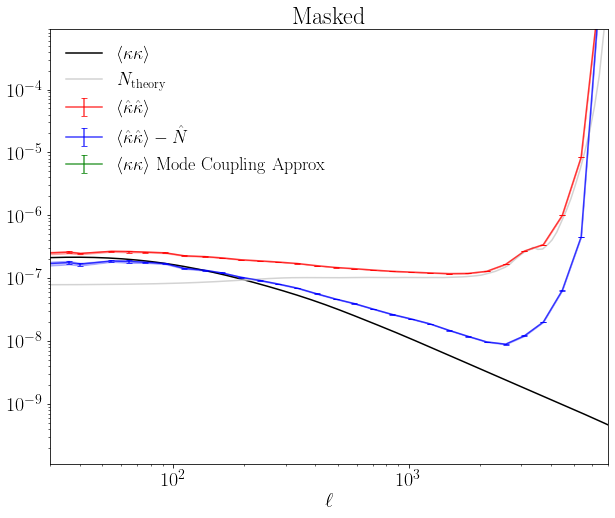

In [54]:
graph_from_keys_legacy([
#     'QEQE-N0',
#     'Nhat',
    'QEQE',
    'QEQE-Nhat',
    'kTW2',
#     'QEQE-RDN(0)',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.00)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


500 (500, 3, 50)
500 (500, 3, 50)


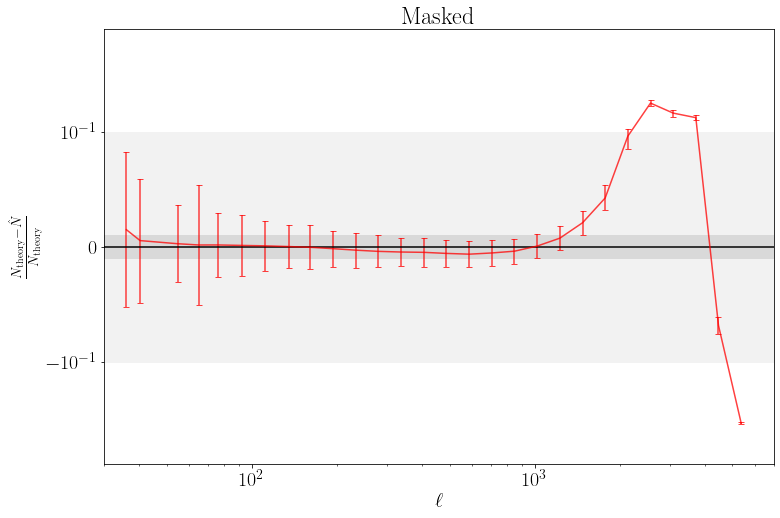

In [22]:
offset=0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(12,8))


plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

ell = baseMap.l.flatten()

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['QEQE-Ntheory']))
lCen1, Cl1, sCl1 = combine_Cl(np.array(ps_data['QEQE-Nhat']))

assert(all(lCen0 == lCen1))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl0), yerr=sCl1/Cl0, alpha=0.75, 
            fmt='-', capsize=3, capthick=1, c='red')#, label=labels[key], c=colors[key])
ax.set_title('Masked')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{N_{\rm theory} - \hat N}{N_{\rm theory}}$')

ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)

ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
ax.set_yscale('symlog', linthresh=1e-1) 

ax.axhline(0, c='k')

ax.set_ylim(-.98e0, .98e0)
plt.savefig('figures/mNhat_vs_mNtheory_masked.pdf', bbox_inches='tight')

500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


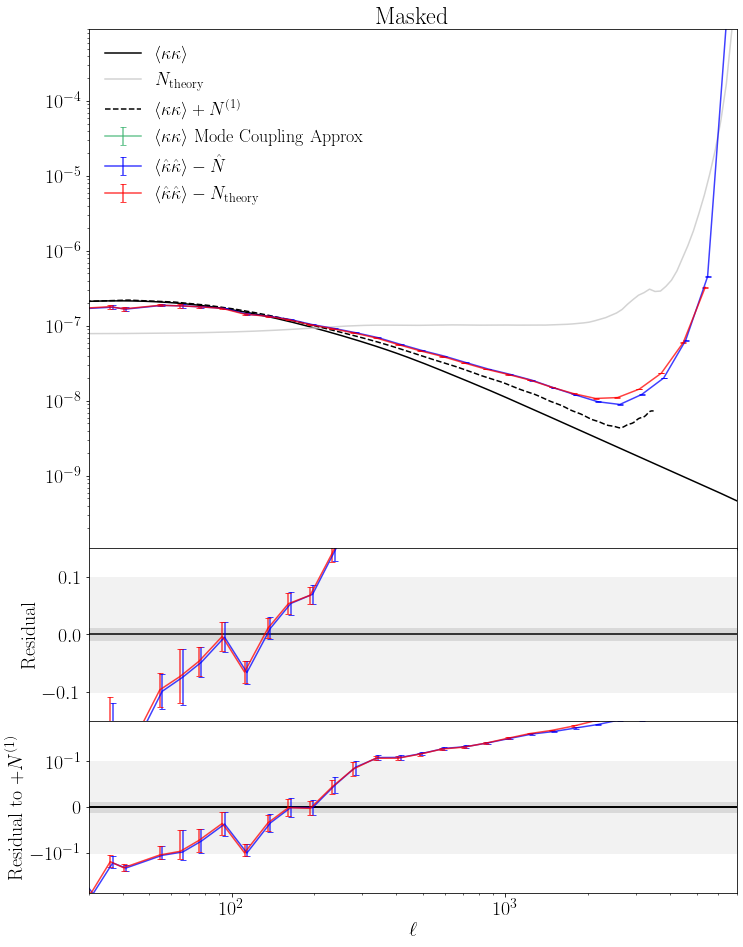

In [37]:
graph_from_keys([
#     'QEQE-N0',
    'QEQE-Ntheory',
    'QEQE-Nhat',
    'kTW2',
#     'QEQE-RDN(0)',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.02, pN1=True)
plt.savefig('figures/mNhat_vs_mNtheory_masked_explicit.pdf', bbox_inches='tight')

In [ ]:
graph_from_keys_legacy([
#     'QEQE-N0',
    'Nhat',
#     'QEQE-RDN(0)',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.02)#, pN1=True)
plt.savefig('figures/Nhat TgradT masked.pdf', bbox_inches='tight')

In [ ]:
# ps_data['QEQE-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['RDN(0)o2']])
# graph_from_keys([
# #     'QEQE-N0',
#     'QEQE-Ntheory',
#     'QEQE-Nhat',
#     'QEQE-RDN(0)',
# #     'RDN(0)o2'
# #     'QEQE-2Nhat+Ntheory',
# ], offset=0.00)
# plt.savefig('figures/mNhat_vs_mNtheory_vs_RDN0.pdf', bbox_inches='tight')

In [ ]:
nBins=15

ps_data = {}

# #estimate RDN0
# ck = 'RDN(0)'

# def tmp_combine_Cl(Cls_tot):
#     n_runs = np.shape(Cls_tot)[0]
#     lCen = Cls_tot[0][0]
#     Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
# #     sCls =  np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))
#     return lCen, Cls, sCls


# for d_idx in trange(len(in_data['totalF_1'])):
#     RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d.pkl'%(d_idx)
#     c_ps_data = None
#     try:
#         with open(RDN0_fname,"rb") as f:
#             c_ps_data = pickle.load(f)
#     except IOError:
#         continue
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array(c_ps_data[ck])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array(c_ps_data[ck])))  
# print(ps_data[ck].shape)

# #estimate N0
# ck = 'N0'

# for data_idx in range(len(data['00'])):
#     q00 = data['00'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  



# #estimate kk
# ck = 'kk'


# for data_idx in range(min(len(data['01']), len(data['10']))):
#     q01 = data['01'][data_idx]
#     q10 = data['10'][data_idx]
#     kCmbFourier = in_data['kCmbF_1'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier, nBins=15)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <QE QE>
ck = 'QEQE'
for data_idx in trange(len(data['-1-1_m'])):
    QE = data['-1-1_m'][data_idx]

    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE-mean_field, nBins=nBins)
    c_ps_data[ck][1] /= fsky
    c_ps_data[ck][2] /= fsky

    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate Nhat
ck = 'Nhat'
for data_idx in trange(len(data['-1-1_m_sqrtN'])):
    sqrtNhat = data['-1-1_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    c_ps_data[ck][1] /= fsky**2
    c_ps_data[ck][2] /= fsky**2
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  

#estimate GRF Nhat
ck = 'GRF'
for data_idx in trange(len(data['-2-2_m_sqrtN'])):
    sqrtNhat = data['-2-2_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <kT kT>
ck = 'kT'

for data_idx in trange(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=kT, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  





ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])



import numpy as np
from multiprocessing import Pool
from tqdm import trange

# Define a function to compute Ntheory_evaled for a given iteration
def compute_Ntheory_evaled(_):
    # Replace your original code here
    t0, t1 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
    t2 = np.zeros_like(t1)
    return [t0, t1, t2]

# Set the number of iterations for parallel processing
num_iterations = 500

# Create a pool of worker processes using all available CPU cores
pool = Pool()

# Use the map function to parallelize the computation of Ntheory_evaled
Ntheory_evaled = list(tqdm(pool.imap(compute_Ntheory_evaled, range(num_iterations)), total=num_iterations))

# Convert the list of results to a NumPy array
Ntheory_evaled = np.array(Ntheory_evaled)

# Clean up the pool of worker processes
pool.close()
pool.join()

# Continue with your original code
ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-Ntheory_evaled])

In [ ]:
# f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_masked_fewer_bins_lensed_weights.pkl', 'wb') 
# pickle.dump(ps_data, f)
# f.close()


In [ ]:
#bandaid
ll = ['%d'%l for l in ps_data['QEQE'][0][0]]
#
def corr2(corr_nhat1, 
          corr_nhat2, 
          filename_base, 
          cmap='seismic', 
          cmap2='seismic', 
          label='', 
          label2=''):
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20
    plt.rcParams['text.latex.preamble'] = r'\usepackage{xcolor}'
    plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] += r'\definecolor{c1}{rgb}{%.1f,%.1f,%.1f}'%(cmap[3][0],cmap[3][1],cmap[3][2])
#     plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] +=r'\definecolor{c2}{rgb}{%.1f,%.1f,%.1f}'%(cmap2[3][0],cmap2[3][1],cmap2[3][2])

    
    corr_nhat = np.copy(corr_nhat1)
    sze = len(corr_nhat1)
    mask = np.array([[0 for _ in range(sze)] for _ in range(sze)])
    for i in range(sze-1):
        for j in range(sze-1-i):
            corr_nhat[i][sze-j-1] = corr_nhat2[i][sze-j-1]
            mask[i][sze-j-1] = 1
    plt.figure(figsize=(25,20))
    print(np.shape(corr_nhat))
    print(np.shape(mask))
    
    ax = sns.heatmap(corr_nhat,  cmap=cmap, cbar=True, vmin=-1, vmax=1, square=True,
                    cbar_kws={ 'ticks':[],
                              "orientation": "horizontal", 'pad':-0.17, 'shrink':0.3})
    
    sns.heatmap(corr_nhat, mask=mask, cmap=cmap2, cbar=True, ax=ax, vmin=-1, vmax=1,square=True,label=label,
           cbar_kws={'label': r"$\rho$","orientation": "horizontal", 'pad':0.1,  'shrink':0.3})
    

    ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
    ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
    plt.xlabel(r'$\ell$'+'\n')

#     ax.legend(frameon=False)

    ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
    ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
    plt.ylabel(r'$\ell$'+'\n')

    plt.title(r'Correlations for {%s} (Top Left) and {%s} (Bottom Right)'%(label, label2))
    plt.xlim(4, len(ll)-1)
    plt.ylim(4, len(ll)-1)

    plt.savefig('figures/corr_%s_masked_TgradT_weights.pdf'%(filename_base), bbox_inches='tight')#, use='pgf')


def corr_gen(keys, filename_base):
    Cls_tmp = np.array([None, None])
    for key,idx in zip(keys, range(2)):
        print(np.shape(ps_data[key]))
        Cls_tmp[idx] = np.transpose(np.copy(np.array(ps_data[key])), axes=[1,2,0])[1]

    corrs = np.array([[[(np.corrcoef(Cls_tmp[i][i1], Cls_tmp[i][i2])[1,0])
                          for i1 in range(len(Cls_tmp[i]))]
                         for i2 in range(len(Cls_tmp[i]))]
                         for i in range(2)])

    corr2(corrs[0], corrs[1], 
          label= labels[keys[0]],
         label2=labels[keys[1]], 
         filename_base=filename_base)

In [ ]:
# corr_gen(['QEQE', 'N0'], 'QEQEvsN0')

In [ ]:
ps_data['QEQE-kTkT-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-ps_data['Nhat']])
ps_data['QEQE-kTkT-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-Ntheory_evaled])
# ps_data['QEQE-kTkT-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-ps_data['RDN(0)o2']])

In [ ]:
corr_gen(['QEQE-kTkT-Nhat', 'QEQE-kTkT-Ntheory'], 'mNhat_v_mNtheory')

In [ ]:
# corr_gen(['QEQE-kTkT-Nhat', 'QEQE-kTkT-RDN(0)'], 'mNhat_v_mRDN0')